In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score
import collections
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from pickle import load

In [ ]:
pickle_path_feature = "feature.pkl"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_data(data_path):
     #Loads training dataset from data file.
     #   :return X (ndarray)
     #   :return y (ndarray)

    data = load(open(data_path, 'rb'))

    # convert lists to numpy arrays
    X = np.array(data["feauture_mfcc"])
    y = np.array(data["labels"])
#    pad_len = 55
#    X = [np.pad(x, ((0, 0), (0, pad_len)), 'constant', constant_values=(0))[:, :pad_len] for x in X]
    X = np.array(X)
    print("Data succesfully loaded!")

    return  X, y

In [ ]:
# load data
X, y = load_data(pickle_path_feature)
num_classes = 10
 # create train, validation and test split
X = X.reshape(-1,X.shape[1],X.shape[2],1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.1)
X_train.shape, X_validation.shape, X_test.shape

Data succesfully loaded!


((2295, 55, 13, 1), (255, 55, 13, 1), (450, 55, 13, 1))

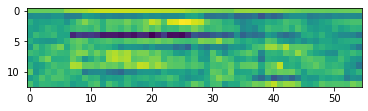

In [ ]:
plt.imshow(X_train[2,:,:,0].T)

In [ ]:
BUFFER_SIZE = X_train.shape[0]
BATCH_SIZE = 64
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=False)

In [ ]:
for x,y in dataset:
  print(x.shape)
  break

(64, 55, 13, 1)


In [ ]:
BUFFER_SIZE_TEST = X_test.shape[0]
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(BUFFER_SIZE_TEST)
dataset_test = dataset_test.batch(BATCH_SIZE, drop_remainder=False)

In [ ]:
BUFFER_SIZE_VAL = X_validation.shape[0]
dataset_val = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).shuffle(BUFFER_SIZE_VAL)
dataset_val = dataset_test.batch(BATCH_SIZE, drop_remainder=False)

In [ ]:
projection_dim = 64
num_heads = 4
image_size = 72
last_layer = 128
mlp_dim =128
transformer_layers = 4
image_size = 76  # We'll resize input images to this size
patch_size = 4  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2

In [ ]:
num_patches

361

In [ ]:
class MLP(tf.keras.layers.Layer):
  def __init__(self, projection_dim, mlp_dim, dropout=0.1):
        super(MLP, self).__init__()
  
        self.Dense1 = layers.Dense(mlp_dim, activation=tf.nn.gelu)
        self.dropout1 = layers.Dropout(dropout)
        self.Dense2 = layers.Dense(projection_dim, activation=tf.nn.gelu)
        self.dropout2 = layers.Dropout(dropout)
  def call(self, x):
        x = self.Dense1(x)
        x = self.dropout1(x)
        x = self.Dense2(x)
        x = self.dropout2(x)
        return x

In [ ]:
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, projection_dim, num_heads, mlp_dim, dropout=0.2):
        super(EncoderBlock, self).__init__()
        self.mlp_dim = mlp_dim
        self.projection_dim = projection_dim
        self.num_heads = num_heads
        self.dropout = dropout

        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(dropout)
        self.dropout2 = tf.keras.layers.Dropout(dropout)
        self.mlp      = MLP(projection_dim, mlp_dim, dropout)
  
    def call(self, inputs, training):
        inputs_norm = self.layernorm1(inputs)
        attn_output, atten_weight = self.mha(inputs_norm,inputs_norm, return_attention_scores=True)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = attn_output + inputs

        out1_norm = self.layernorm2(out1)
        mlp_output = self.mlp(out1_norm)
        mlp_output = self.dropout2(mlp_output, training=training)
        return mlp_output + out1, atten_weight

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


In [ ]:
class VisionTransformer(tf.keras.Model):
    def __init__(self, image_size, patch_size, transformer_layers, num_classes,  projection_dim, num_heads, mlp_dim, last_layer=128, dropout=0.5):
        super(VisionTransformer, self).__init__()
        num_patches = (image_size // patch_size) ** 2

        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.transformer_layers = transformer_layers
        self.last_layer = last_layer
        self.data_augmentation = keras.Sequential(
          [
          layers.experimental.preprocessing.Normalization(),
          layers.experimental.preprocessing.Resizing(image_size, image_size),
          layers.experimental.preprocessing.RandomFlip("horizontal"),
          layers.experimental.preprocessing.RandomRotation(factor=0.02),
          layers.experimental.preprocessing.RandomZoom(
              height_factor=0.2, width_factor=0.2
          )
          ],
          name="data_augmentation",
          )      
        self.encoded_patches = PatchEncoder(num_patches, projection_dim)        



        self.enc_layers = [
            EncoderBlock(projection_dim, num_heads, mlp_dim, dropout)
            for _ in range(transformer_layers)
        ]

        self.LayerNormalization1 = layers.LayerNormalization(epsilon=1e-6)
        self.Flattern = layers.Flatten()
        self.dropout = layers.Dropout(0.5)
        self.mlp_last =  MLP(mlp_dim, projection_dim*4, dropout)
        self.feature = layers.Dense(num_classes)

    def Patches(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches



    def call(self, x, training):
        batch_size = tf.shape(x)[0]
        x = self.data_augmentation(x)
        patches = self.Patches(x)
        x =  self.encoded_patches(patches)
        attention_weights = {}
        for i,layer in enumerate(self.enc_layers):
            x, block = layer(x, training)
            attention_weights[f'decoder_layer{i+1}_block'] = block
            
        x = self.LayerNormalization1(x)
        x = self.Flattern(x)
        x = self.dropout(x)
        # First (class token) is used for classification
        x = self.mlp_last(x)
        logits = self.feature(x)

        return logits, attention_weights

In [ ]:
transformer = VisionTransformer(image_size, patch_size, transformer_layers, num_classes,  projection_dim, num_heads, mlp_dim, last_layer=128, dropout=0.5)
transformer.data_augmentation.layers[0].adapt(X_train)

In [ ]:
for (batch, (inp, tar)) in enumerate(dataset):
     print(inp.shape)
     break
transformer(inp, True)[0].shape

(64, 55, 13, 1)


TensorShape([64, 10])

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)


In [ ]:
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [ ]:
@tf.function
def train_step(inp, tar):
  with tf.GradientTape() as tape:
    logits, attention_weights = transformer(inp, True)
    loss = loss_object(tar, logits)
  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  train_accuracy.update_state(tar, logits)
  return loss
def val_step(inp, tar):
    logits, attention_weights = transformer(inp, False)
    val_accuracy.update_state(tar, logits)

In [ ]:
EPOCHS = 100
history = {
  "epoch": [],
  "loss": []  
}
for epoch in range(EPOCHS):
  start = time.time()
  total_loss = 0
  # TRAIN LOOP
  for (batch, (inp, tar)) in enumerate(dataset):
    batch_loss = train_step(inp,tar)
    total_loss = total_loss + batch_loss
  history['epoch'].append(epoch)
  history['loss'].append(total_loss/(batch+1))
  # TEST LOOP

  if (epoch+1) % 1 == 0: 
     val_step(X_validation, y_validation)
     print(f'Epoch {epoch+1}, Loss: {total_loss/(batch+1):.4f}, Accuracy: {train_accuracy.result():.4f}, Validation Accuracy: {val_accuracy.result():.4f}') 
     print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
  # if (epoch+1) % 1 == 0:    
  #    print(f'Epoch {epoch + 1} Loss {total_loss/(batch+1):.4f}')
  #    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
  train_accuracy.reset_states()
  val_accuracy.reset_states()

Epoch 1, Loss: 4.0380, Accuracy: 0.1124, Validation Accuracy: 0.1059
Time taken for 1 epoch: 9.06 secs

Epoch 2, Loss: 3.0595, Accuracy: 0.1224, Validation Accuracy: 0.1373
Time taken for 1 epoch: 3.74 secs

Epoch 3, Loss: 2.5641, Accuracy: 0.1264, Validation Accuracy: 0.1059
Time taken for 1 epoch: 3.73 secs

Epoch 4, Loss: 2.3788, Accuracy: 0.1224, Validation Accuracy: 0.0745
Time taken for 1 epoch: 3.73 secs

Epoch 5, Loss: 2.3186, Accuracy: 0.1307, Validation Accuracy: 0.1294
Time taken for 1 epoch: 3.73 secs

Epoch 6, Loss: 2.3073, Accuracy: 0.1290, Validation Accuracy: 0.1765
Time taken for 1 epoch: 3.73 secs

Epoch 7, Loss: 2.2814, Accuracy: 0.1447, Validation Accuracy: 0.1882
Time taken for 1 epoch: 3.73 secs

Epoch 8, Loss: 2.2783, Accuracy: 0.1399, Validation Accuracy: 0.1176
Time taken for 1 epoch: 3.73 secs

Epoch 9, Loss: 2.2655, Accuracy: 0.1325, Validation Accuracy: 0.2549
Time taken for 1 epoch: 3.73 secs

Epoch 10, Loss: 2.2417, Accuracy: 0.1577, Validation Accuracy: 0

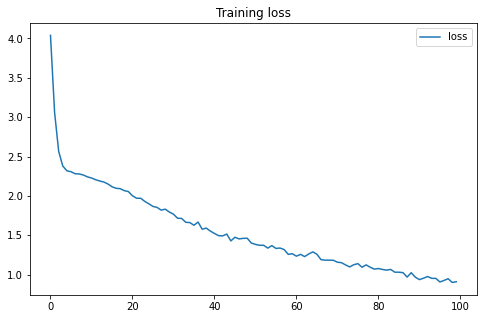

In [ ]:
plt.figure(figsize=(8,5))
#plt.yscale("log")
plt.plot(history["epoch"],history["loss"], label='loss')
plt.title('Training loss')
plt.legend(loc='best')
plt.show()

In [ ]:
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [ ]:
log_ = []
y_t = []
for X_test, y_test in dataset_test:
    logits,_ = transformer(X_test, False)
    y_predic = tf.argmax(logits, axis=1)
    log_.extend(y_predic.numpy())
    y_t.extend(y_test.numpy())

In [ ]:
y_predic = np.asarray(log_)
y_test =  np.asarray(y_t)

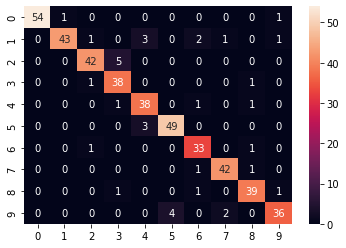

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(y_test, y_predic)
sns.heatmap(cf_matrix, annot=True);